# File Info

Sample Training code for neural ODEs.

Learns non-choatic Lorenz with fixed bifurcation parameter. 

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v2 as nodes
import models.DynamicalSystems as ds
from models.Methods import LLEwolfs as lle

# Data Generation



In [2]:
lorenz = ds.Lorenz(sigma=10.0, rho=15.0, beta=8.0 / 3.0)

In [3]:
lorenz.drive_rate = 0.5

In [4]:
a = torch.linspace(-10, 10, 5)
r_val = torch.arange(10, 20, 2.0)
ic = torch.cartesian_prod(a, a, a, r_val)

lorenz.f = lorenz.na_f


dt = 0.05
sol = lorenz.solve(x0=ic, t_span=(0, 10), dt=dt)
sol.shape

torch.Size([200, 625, 4])

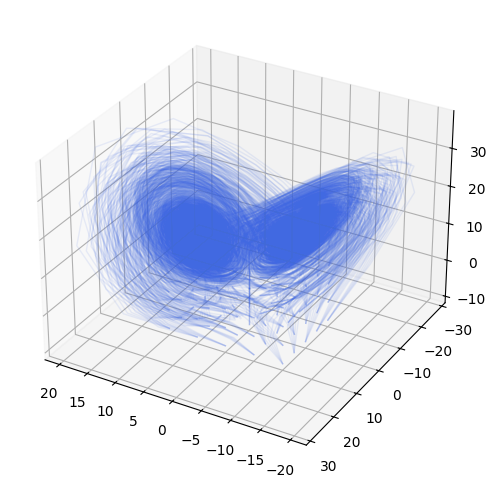

In [5]:
#Plotting data by subplots 
#Normalised Plot
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
for i in range(sol.shape[1]):
    ax1.plot(xs=sol[:, i, 0], ys=sol[:, i, 1], zs=sol[:, i, 2], linewidth = 1, alpha = 0.1, color='royalblue')



ax1.view_init(elev = 30, azim = 120)

In [6]:
sol.shape

torch.Size([200, 625, 4])

In [7]:
def data_loader_format(data, pts=2):
    # Pairwise data
    # data input shape: (time, trajectories, dim)
    num_pts = pts
    data_tensor = torch.stack((data[0:-(num_pts-1), :, :], data[num_pts-1:, :, :]), dim=1)

    list = []
    for i in range(data_tensor.shape[2]):
        list.append(data_tensor[:,:,i,:])

    data_tensor1 = torch.concat(list, dim=0)
   
    return data_tensor1

In [8]:
data_tensor1 = data_loader_format(sol, pts=2) 
data_loader = torch.utils.data.DataLoader(data_tensor1, batch_size=512, shuffle=True)

In [9]:
data_loader.dataset.shape #Num pairs - traj - dim

torch.Size([124375, 2, 4])

# Model 

In [10]:
model = nodes.driven_neural_ODE(input_dim=3, drivers=1, output_dim=3, hidden_dim=32, depth=5, activation_func=nn.Tanh())

In [11]:
model.drdt = lorenz.drive_rate

In [12]:
t_eval = torch.arange(0, 0.1, dt)
print(t_eval)

#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

tensor([0.0000, 0.0500])


In [13]:
trainer = nodes.Trainer(model=model, data_loader=data_loader, optimizer=optimizer, loss_fn=loss_fn, t_eval=t_eval, dt=dt) # 

In [14]:
trainer.train(num_epochs=300, t_eval=t_eval)

Current Loss: 0.9103882908821106  - Epochs: 0: 100%|██████████| 300/300 [01:58<00:00,  2.52it/s]


In [15]:
torch.save(model, 'lorenz_bif_neural_ODE_v1.pt')

In [15]:
model = torch.load('lorenz_bif_neural_ODE_v1.pt', weights_only=False)

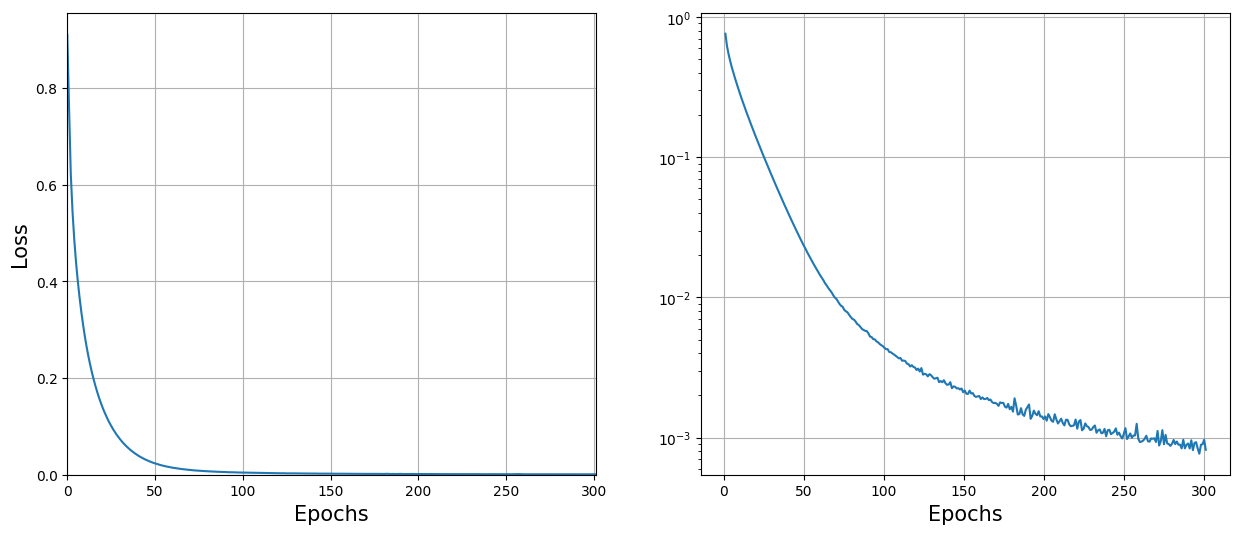

In [16]:
trainer.plot_loss()

In [17]:
print('Final Loss: ' + str(trainer.loss()))

Final Loss: 0.0008571987273171544


# Analyzing the trained model

## Data Generation with trained NODE

a = torch.linspace(-10, 10, 5)
r_val = torch.arange(10, 20, 2.0)
ic = torch.cartesian_prod(a, a, a, r_val)

    
    

In [18]:
a = torch.tensor([[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]])
r_val = torch.arange(10, 30, 0.5)

In [19]:
r_val_reshape = torch.sort(r_val.unsqueeze(1).repeat(a.shape[0], 1), dim=0)[0]
a_val_reshape = a.repeat(r_val.shape[0], 1)         

In [20]:
ic = torch.cat((a_val_reshape, r_val_reshape), dim=1)

In [22]:
lorenz.drive_rate = 0.0
model.drdt = lorenz.drive_rate

In [23]:
t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)


node_data = odeint(func=model, y0=ic, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lorenz.f, y0=ic, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})



node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

(400, 80, 4)
(400, 80, 4)


## Plotting phase space

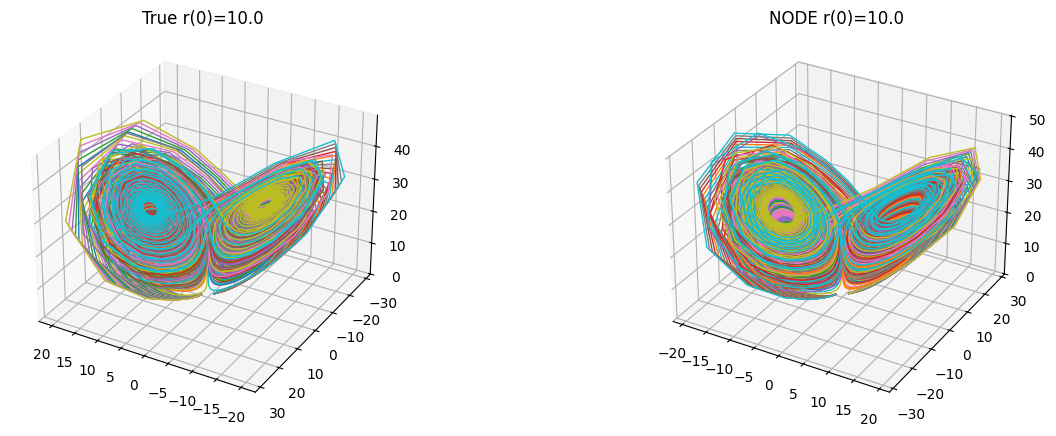

In [24]:


fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

#ax1.plot(node_data[:, :, 0],
 #               node_data[:, :, 1], node_data[:, :, 2],
 #               linewidth=0.5, linestyle='--', color='royalblue')

#Normalised Plot

for i in range(true_data.shape[1]):
    ax1.plot(xs=true_data[:, i,  0], ys=true_data[:, i, 1], zs=true_data[:, i, 2], linewidth = 1 )

for i in range(node_data.shape[1]):
    ax2.plot(xs=node_data[:, i,  0], ys=node_data[:, i, 1], zs=node_data[:, i, 2], linewidth = 1)


ax1.view_init(elev = 30, azim = 120)
ax1.set_title(f"True r(0)={10.0}")
ax2.set_title(f"NODE r(0)={10.0}")
plt.show()

In [301]:
# Plotting time traces: 

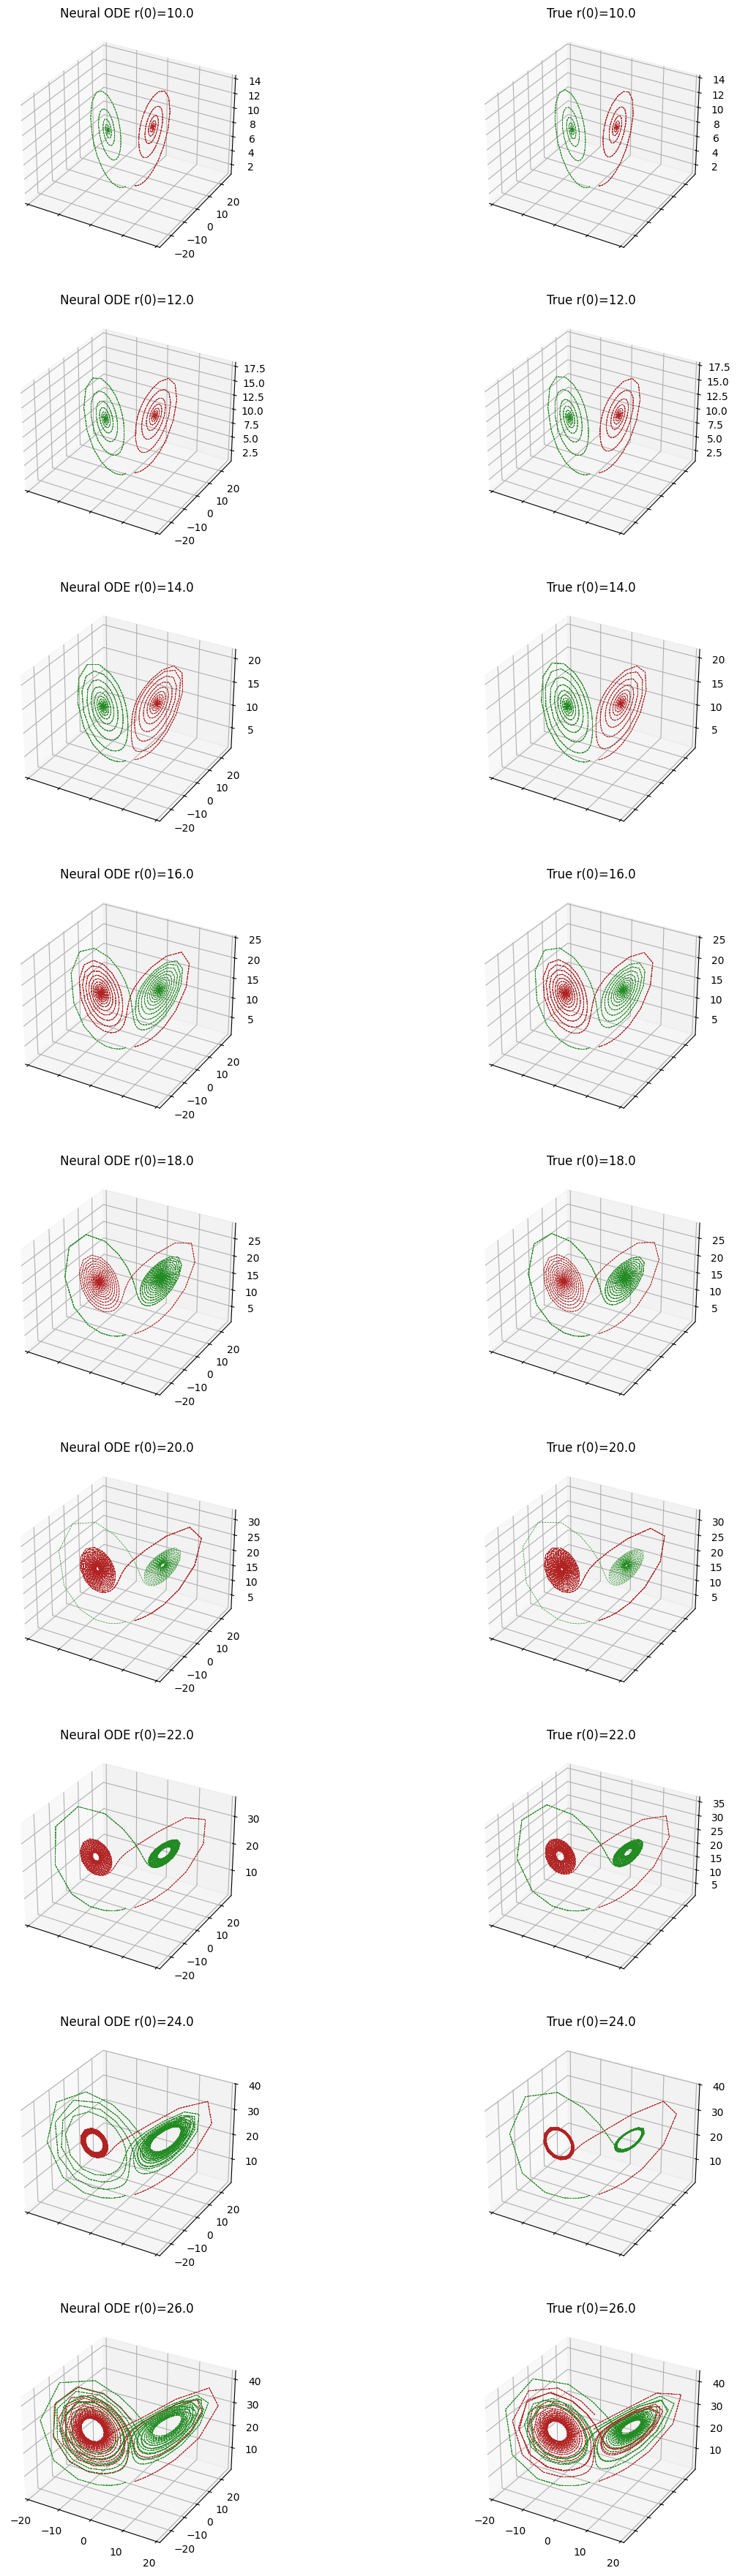

<Figure size 1500x500 with 0 Axes>

In [25]:
r_plots = [10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), subplot_kw={'projection': '3d'}, sharex=True, sharey=True)


fig = plt.figure(figsize=(15, 5))


for i, r in enumerate(r_plots):
    current_node_data = node_data[:, ic[:, 3] == r, :]
    current_true_data = true_data[:, ic[:, 3] == r, :]
    indices = np.random.randint(0, current_true_data.shape[1], 10)
    colors = ['firebrick', 'forestgreen']
    for k in indices:
            axes[i, 0].plot(current_node_data[:, k, 0],
                        current_node_data[:, k, 1], 
                        current_node_data[:, k, 2],
                        linewidth=0.5, alpha=1, linestyle='--', color=colors[k])
            axes[i, 1].plot(current_true_data[:, k, 0],
                            current_true_data[:, k, 1],
                            current_true_data[:, k, 2],
                            linewidth=0.5, alpha=1, linestyle='--', color=colors[k])
            axes[i, 0].set_title(f"Neural ODE r(0)={r}")
            axes[i, 1].set_title(f"True r(0)={r}")

  

plt.tight_layout()
plt.show()

In [270]:
# Lyapunov Exponent Calculation:

In [ ]:
epsilon = 5
dim = 4

In [227]:
true_data.shape

(400, 80, 4)

In [228]:
list = []
for i in tqdm(range(true_data.shape[1])):
    list.append(lle(TimeSeries=true_data[:, i, 0], theta_max = np.pi/6, 
           epsilon = epsilon, EmbeddingDim = dim, NN_max = 50, 
           Max_iterations = 10000, TimeSeries_dt=0.01, ReplaceTime = 10)[0])

 75%|███████▌  | 60/80 [00:04<00:01, 14.64it/s]

No valid nearest neighbour on iteration j =  0


TypeError: 'float' object is not subscriptable

In [ ]:
le_true = np.sort(np.array(list))
ic_true_sort = np.sort(ic[:, 3])

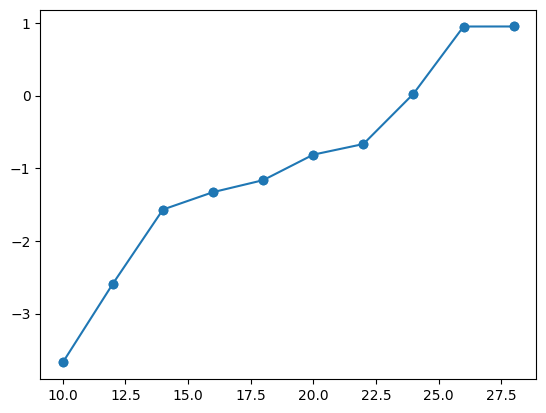

In [149]:
plt.plot(ic_true_sort, le_true, marker='o')

In [156]:
epsilon = 6
dim = 5

In [171]:
list = []
for i in tqdm(range(node_data.shape[1])):
    list.append(lle(TimeSeries=node_data[:, i, 0], theta_max = np.pi/6, 
           epsilon = epsilon, EmbeddingDim = dim, NN_max = 50, 
           Max_iterations = 10000, TimeSeries_dt=0.05, ReplaceTime = 10))

 45%|████▌     | 9/20 [00:00<00:00, 17.61it/s]

End of Time Series: i =  395
No valid nearest neighbour on iteration j =  0


100%|██████████| 20/20 [00:01<00:00, 18.39it/s]

End of Time Series: i =  395
No valid nearest neighbour on iteration j =  0


In [165]:
list

[array([-4.38112167]),
 array([-2.7185051]),
 array([-1.02031884]),
 array([-1.98822822]),
 array([-1.4738653]),
 array([-1.40522145]),
 array([2.04148854]),
 array([-1.08438011]),
 array([5.54121134]),
 array(0.),
 array([-4.38112167]),
 array([-2.7185051]),
 array([-1.02031884]),
 array([-1.98822822]),
 array([-1.4738653]),
 array([-1.40522145]),
 array([2.04148854]),
 array([-1.08438011]),
 array([5.54121134]),
 array(0.)]

In [174]:
list[9] = np.array([list[9]])
list[19] = np.array([list[19]])

In [175]:
le_node = np.sort(np.array(list))
ic_node_sort = np.sort(ic[:, 3])

In [ ]:
le

In [180]:
ic_true_sort[:-2]

array([10., 10., 12., 12., 14., 14., 16., 16., 18., 18., 20., 20., 22.,
       22., 24., 24., 26., 26.], dtype=float32)

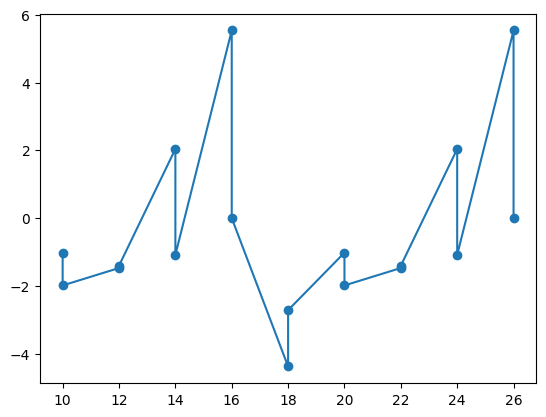

In [186]:
plt.plot(ic_node_sort[:-2], le_node[2:, 0], marker='o')